## The goal of this notebook is to show how one can employ Logistic Regression to classify of the 2D Ising model according to their phase.  In other words, given an Ising state, we would like to classify whether it belongs to the ordered or the disordered phase, without any additional information other than the spin configuration itself. Moreover, I will discuss overfitting, regularization and learn how to use the sci-kit learn.  And we will also examine the role of the optimizer in making predictions.

#### Preparing the 2D Ising model on a $40\times 40$ square lattice, and use Monte-Carlo sampling to prepare $10^4$ states at every fixed temperature $T$ out of a pre-defined set $T\in[0.25,0.5,\cdots,4.0]$

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed()

L = 40
J = -1.0
T = np.linspace(0.25,4.0,16)
T_c = 2.26 # theoretically critical temperature


#### Load data

In [3]:
import pickle, os
from urllib.request import urlopen


url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/'
data_file_name = 'Ising2DFM_reSample_L40_T=All.pkl'
label_file_name = 'Ising2DFM_reSample_L40_T=All_labels.pkl'

data = pickle.load(urlopen(url_main+data_file_name))
data = np.unpackbits(data).reshape(-1,1600).astype('int')
data[np.where(data==0)] = -1
# Convention is 1 for ordered states and 0 for disordered states
labels = pickle.load(urlopen(url_main+label_file_name))


#### Constructing the Training and the test sets

In [10]:
from sklearn.model_selection import train_test_split

num_classes = 2
train_to_test_ratio = 0.2

X_ordered = data[:70000,:]
Y_ordered = labels[:70000]

X_critical = data[70000:100000,:]
Y_critical = labels[70000:100000]

X_disordered = data[100000:,:]
Y_disordered = labels[100000:]


X = np.concatenate((X_ordered, X_disordered))
Y = np.concatenate((Y_ordered, Y_disordered))

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=train_to_test_ratio)

del data, labels

X = np.concatenate((X, X_critical))
Y = np.concatenate((Y, Y_critical))

print ('X_train shape:', X_train.shape)
print ('Y_train shape:', Y_train.shape)
print ()
print (X_train.shape[0], 'train samples')
print (X_critical.shape[0], 'critical samples')
print (X_test.shape[0], 'test samples')



X_train shape: (104000, 1600)
Y_train shape: (104000,)

104000 train samples
30000 critical samples
26000 test samples


#### Visualizing the states

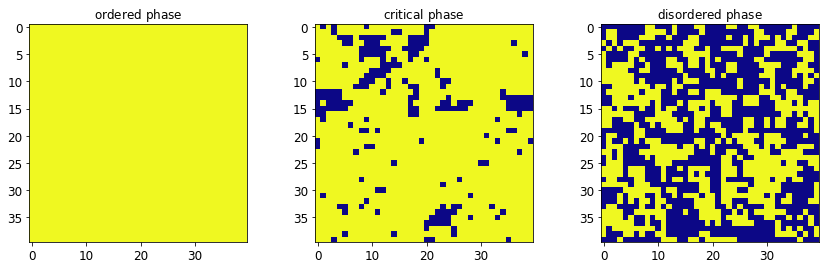

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap_args = dict(cmap='plasma_r')

fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[20001].reshape(L,L),**cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$', fontsize=12)
axarr[0].tick_params(labelsize=12)

axarr[1].imshow(X_critical[10001].reshape(L,L),**cmap_args)
axarr[1].set_title('$\\mathrm{critical\\ phase}$', fontsize=12)
axarr[1].tick_params(labelsize=12)

im = axarr[2].imshow(X_disordered[50001].reshape(L,L),**cmap_args)
axarr[2].set_title('$\\mathrm{disordered\\ phase}$', fontsize=12)
axarr[2].tick_params(labelsize=12)

fig.subplots_adjust(right=2.0)
plt.show()

In [16]:
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
 
lmbdas = np.logspace(-5,5,11)

train_accuracy    = np.zeros(lmbdas.shape,np.float64)
test_accuracy     = np.zeros(lmbdas.shape,np.float64)
critical_accuracy = np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD    = np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD     = np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD = np.zeros(lmbdas.shape,np.float64)
print (train_accuracy.shape)

(11,)


accuracy: train, test, critical
liblinear: 0.7113, 0.6803, 0.6347
SDG: 0.4844, 0.4844, 0.4844
finished computing 1/11 iterations
accuracy: train, test, critical
liblinear: 0.7113, 0.6803, 0.6347
SDG: 0.4876, 0.4876, 0.4876
finished computing 2/11 iterations
accuracy: train, test, critical
liblinear: 0.7113, 0.6803, 0.6347
SDG: 0.7194, 0.7194, 0.7194
finished computing 3/11 iterations
accuracy: train, test, critical
liblinear: 0.7113, 0.6803, 0.6347
SDG: 0.4496, 0.4496, 0.4496
finished computing 4/11 iterations
accuracy: train, test, critical
liblinear: 0.7113, 0.6803, 0.6347
SDG: 0.6499, 0.6499, 0.6499
finished computing 5/11 iterations
accuracy: train, test, critical
liblinear: 0.7113, 0.6803, 0.6347
SDG: 0.5398, 0.5398, 0.5398
finished computing 6/11 iterations
accuracy: train, test, critical
liblinear: 0.7112, 0.6802, 0.6347
SDG: 0.4611, 0.4611, 0.4611
finished computing 7/11 iterations
accuracy: train, test, critical
liblinear: 0.7109, 0.6797, 0.6355
SDG: 0.4611, 0.4611, 0.4611
fin

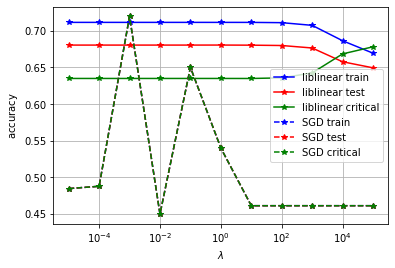

In [31]:
for i, lmbda in enumerate(lmbdas):
    logreg = linear_model.LogisticRegression(C=1.0/lmbda, random_state=42, verbose=0, max_iter=1E3,tol=1E-5, solver='liblinear')
    logreg.fit(X_train, Y_train)
    
    train_accuracy[i] = logreg.score(X_train,Y_train)
    test_accuracy[i] = logreg.score(X_test,Y_test)
    critical_accuracy[i] = logreg.score(X_critical,Y_critical)
    
    print ('accuracy: train, test, critical')
    print ('liblinear: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]))
    
    logreg_SGD = linear_model.SGDClassifier(loss='log',penalty='l2',alpha=lmbda,max_iter=100,shuffle=True,random_state=42,learning_rate='optimal')
    logreg_SGD.fit(X_train, Y_train)
           
    train_accuracy_SGD[i] = logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i] = logreg_SGD.score(X_train,Y_train)
    critical_accuracy_SGD[i] = logreg_SGD.score(X_train,Y_train)
           
    print ('SDG: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]))
    
    print ('finished computing %i/11 iterations' %(i+1))

plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train')
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')
plt.grid()
plt.legend()
plt.show()